# クラス分類モデルの学習方法
https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/1_Learning%20PyTorch/1_4_cifar10_tutorial_jp.ipynb

In [1]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=True, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


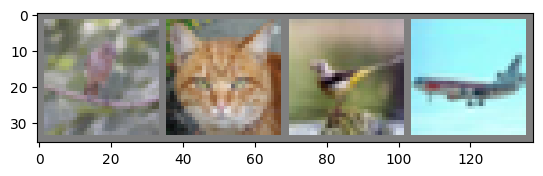

 bird   cat  bird plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.size())

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("[%d %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finish Training")

[1  2000] loss: 2.263
[1  4000] loss: 1.890
[1  6000] loss: 1.728
[1  8000] loss: 1.622
[1 10000] loss: 1.551
[1 12000] loss: 1.499
[2  2000] loss: 1.426
[2  4000] loss: 1.408
[2  6000] loss: 1.366
[2  8000] loss: 1.328
[2 10000] loss: 1.332
[2 12000] loss: 1.299
Finish Training


In [7]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

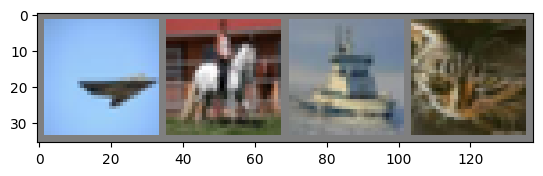

GroundTruth:  plane horse  ship   cat


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:  plane horse  ship  frog


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(
    "Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total)
)

Accuracy of the network on the 10000 test images: 53 %


In [13]:
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print(
        "Accuracy of %5s : %2d %%"
        % (classes[i], 100 * class_correct[i] / class_total[i])
    )

Accuracy of plane : 47 %
Accuracy of   car : 69 %
Accuracy of  bird : 32 %
Accuracy of   cat : 29 %
Accuracy of  deer : 28 %
Accuracy of   dog : 48 %
Accuracy of  frog : 78 %
Accuracy of horse : 55 %
Accuracy of  ship : 76 %
Accuracy of truck : 66 %


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPU搭載のCUDA環境を前提としており、その場合はcuda:0と出力されるはずです

print(device)

cuda


In [15]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
inputs, labels = data[0].to(device), data[1].to(device)

In [ ]:
epochs = 2

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(epochs):  # データセットを何巡繰り返すか

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 入力を取得します; 変数dataはリスト[inputs, labels]です
        # inputs, labels = data  # cpuの場合をコメントアウト
        inputs, labels = data[0].to(device), data[1].to(device)

        # 勾配を0に初期化
        optimizer.zero_grad()

        # 順伝搬、逆伝搬、パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報を出力
        running_loss += loss.item()
        if i % 2000 == 1999:  #  2000ミニバッチごとに出力
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")